In [1]:
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import metrics
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler
from typing import List, Optional
from numpy.typing import NDArray
import matplotlib.pyplot as plt
from typing import Dict, Tuple
import pm4py
from package import transformer
from package.loader import LogsDataLoader
from package.processor import LogsDataProcessor, masked_standard_scaler, masked_min_max_scaler
from package.constants import Feature_Type, Target, Temporal_Feature, Model_Architecture


# Initialize data dir, if not exists
if not os.path.exists("datasets"): 
    os.mkdir("datasets")

# Pipeline

In [2]:
class pipeline:
    
    def __init__(self, dataset_name: str, filepath: str, sorting: bool, columns: List[str],
                 additional_columns: Optional[Dict[Feature_Type, List[str]]],
                 datetime_format: str, model_epochs: int, model_num_layers: int,
                 input_columns: List[str], target_columns: Dict[str, Target], temporal_features: Dict[Temporal_Feature, bool],
                 cross_val: bool, model_architecture: Model_Architecture):
        self.dataset_name: str = dataset_name
        self.filepath: str = filepath
        self.sorting: bool = sorting
        self.columns: List[str] = columns
        self.additional_columns: Optional[Dict[Feature_Type, List[str]]] = additional_columns
        self.datetime_format: str = datetime_format
        self.model_epochs: int = model_epochs
        self.model_num_layers: int = model_num_layers
        
        self.target_columns: Dict[str, Target] = target_columns
        for target_col in target_columns.keys():
            if target_col == columns[1]:
                self.target_columns["concept_name"] = self.target_columns.pop(target_col)
                break
                
        self.input_columns: List[str] = input_columns
        for idx, input_col in enumerate(input_columns):
            if input_col == columns[1]:
                self.input_columns[idx] = "concept_name"
                break
        self.temporal_features: Dict[Temporal_Feature, bool] = temporal_features
        self.cross_val = cross_val
        self.model_architecture = model_architecture
        
    def __str__(self):
        return (
            f"dataset_name: '{self.dataset_name}'\n"
            f"filepath: '{self.filepath}'\n"
            f"columns: '{self.columns}'\n"
            f"additional_columns: '{self.additional_columns}'\n"
            f"datetime_format: '{self.datetime_format}'\n"
            f"Model Epochs: '{self.model_epochs}'\n"
            f"Number of Transformer Layers in Model: '{self.model_num_layers}'\n"
            f"Target columns: '{self.target_columns}'\n"
            f"Input columns: '{self.input_columns}'\n")
        
    
    def save_as_csv(self):
        dir_path = os.path.join( "datasets", self.dataset_name )
        os.makedirs(dir_path, exist_ok=True)
        file_path = os.path.join( dir_path, self.filepath )
        
        
        if file_path.endswith('.xes'):
            print("Converting xes to csv file")
            df = pm4py.convert_to_dataframe(pm4py.read_xes(file_path)).astype(str)
            df.to_csv(file_path.replace(".xes", ".csv"), index=False)
        elif file_path.endswith('.csv'):
            print("Input file already has csv format")
            
    
    # preprocess the event log and save the train-test split as csv files
    def preprocess_log(self) -> List[int]:
        data_processor = LogsDataProcessor(
            name=self.dataset_name,
            filepath=self.filepath,
            sorting=self.sorting,
            columns=self.columns,
            additional_columns=self.additional_columns,  # Add all additional columns here, first all categorical, then all numerical features
            input_columns=self.input_columns,
            target_columns=self.target_columns,
            datetime_format=self.datetime_format,
            temporal_features=self.temporal_features,
            pool=4
        )
        
        # TODO: sanitize columns
        # self.columns = [data_processor.sanitize_filename(col) for col in self.columns]
        
        # self.additional_columns = {
        #                         feature_type: [data_processor.sanitize_filename(feature) for feature in feature_lst] for feature_type,
        #                         feature_lst in self.additional_columns.items()
        #                         } if len(self.additional_columns)>0 else self.additional_columns
        self.target_columns = {data_processor.sanitize_filename(feature, self.columns): target for feature, target in self.target_columns.items()}
        self.input_columns = [data_processor.sanitize_filename(col, self.columns) for col in self.input_columns]
        self.columns = [data_processor.sanitize_filename(col, self.columns) for col in self.columns]
        
        # Preprocess the event log and make train-test split
        data_processor.process_logs()
        # flatten self.additional_columns to get all used features
        self.additional_columns = data_processor.additional_columns
        self.used_features = [item for sublist in self.additional_columns.values() for item in sublist]
        
        
        # TODO: Compute the number of unique classes in each categorical column
        # train_df = pd.read_csv(os.path.join("datasets", self.dataset_name, "processed", f"{self._preprocessing_id}_train.csv"))
        # num_classes_list = data_processor._compute_num_classes(train_df)
        
        # return num_classes_list
    
    
    # load the preprocessed train-test split from the csv files
    def load_data(self) -> Tuple [ LogsDataLoader, Dict[str, pd.DataFrame], Dict[str, pd.DataFrame], Dict[str, Dict[str, int]], Dict[Feature_Type, List[str]] ]:
        data_loader = LogsDataLoader(name=self.dataset_name, sorting=self.sorting, input_columns=self.input_columns,
                                     target_columns=self.target_columns, temporal_features=self.temporal_features)
        train_dfs, test_dfs, word_dicts, feature_type_dict, mask = data_loader.load_data()
        word_dicts = dict(sorted(word_dicts.items()))
        return data_loader, train_dfs, test_dfs, word_dicts, feature_type_dict, mask
    
    
    def prepare_data( self, data_loader, dfs: Dict[str, pd.DataFrame], x_scaler=None, y_scaler=None,
                     train: bool = True) -> Tuple[ Dict[str, NDArray[np.float32]], Dict[str, NDArray[np.float32]], Dict[str, NDArray[np.float32]], int ]:
        print("Preparing data...")
        # initialize max_case_length
        max_case_length = False
        # initialize token dicts
        x_token_dict, y_token_dict, x_token_dict_numerical, y_token_dict_numerical = {}, {}, {}, {}
        
        # initialize case_id_df
        case_ids = next(iter(dfs.values()))["case_id"]
        
        # loop over all feature dfs
        for idx, (feature, feature_df) in enumerate(dfs.items()):
            
            # get current feature_type
            for feature_type, feature_lst in self.additional_columns.items():
                if feature in feature_lst: break
            
            if idx == 0 and train:
                (x_tokens, y_tokens, max_case_length
                ) = data_loader.prepare_data(feature=feature, df=feature_df, max_case_length=True)
            else:
                x_tokens, y_tokens = data_loader.prepare_data(feature=feature, df=feature_df)
            
            if feature_type is Feature_Type.TIMESTAMP or feature_type is Feature_Type.NUMERICAL:
                x_token_dict_numerical.update(x_tokens)
                y_token_dict_numerical.update(y_tokens)
            else:
                # update x_token_dict
                x_token_dict.update(x_tokens)
                y_token_dict.update(y_tokens)
            
        # TODO:
        if len(x_token_dict_numerical) > 0  and len(list(x_token_dict_numerical.values())[0]) > 0:
            # Concatenate all the feature arrays along the rows (axis=0)
            combined_data = np.vstack(list(x_token_dict_numerical.values()))
            if x_scaler is None:
                # Initialize the StandardScaler
                # x_scaler = StandardScaler()
                # x_scaler = MinMaxScaler(feature_range=(0, 30))
                # x_scaler = FunctionTransformer(masked_standard_scaler, kw_args={'padding_value': -1})
                x_scaler = FunctionTransformer(masked_min_max_scaler, kw_args={'padding_value': -1})
                # Fit the scaler on the combined data
                x_scaler.fit(combined_data)
            # Transform the combined data
            scaled_combined_data = x_scaler.transform(combined_data)
            # split the scaled combined data back into the original feature dict
            split_indices = np.cumsum([value.shape[0] for value in x_token_dict_numerical.values()])[:-1]
            scaled_data_parts = np.vsplit(scaled_combined_data, split_indices)
            # Reconstruct the dictionary with scaled data
            scaled_dict = {key: scaled_data_parts[i] for i, key in enumerate(x_token_dict_numerical.keys())}
            # update x_token_dict
            x_token_dict.update(scaled_dict)
        if len(y_token_dict_numerical) > 0:
            # Prepare list to store valid arrays (non-empty)
            valid_arrays = []
            valid_keys = []

            # Check for empty arrays and prepare data for scaling
            for key, value in y_token_dict_numerical.items():
                if value.size > 0:  # Only consider non-empty arrays
                    valid_arrays.append(value.reshape(-1, 1))  # Reshape to 2D
                    valid_keys.append(key)

            # If there are valid arrays to scale
            if valid_arrays:
                combined_data = np.hstack(valid_arrays)  # Horizontal stacking for features

                if y_scaler is None:
                    # Initialize the StandardScaler
                    # y_scaler = StandardScaler()
                    y_scaler = MinMaxScaler(feature_range=(0, 30))
                    # Fit the scaler on the combined data
                    y_scaler.fit(combined_data)

                # Transform the combined data
                scaled_combined_data = y_scaler.transform(combined_data)

                # Split the scaled combined data back into individual features
                scaled_data_parts = np.hsplit(scaled_combined_data, scaled_combined_data.shape[1])

                # Reconstruct the dictionary with scaled data
                scaled_dict = {key: scaled_data_parts[i].flatten() for i, key in enumerate(valid_keys)}

                # Update y_token_dict with the scaled data
                y_token_dict.update(scaled_dict)

            # Handle any empty arrays (if necessary)
            for key, value in y_token_dict_numerical.items():
                if value.size == 0:
                    # Optionally, you can handle empty arrays here, e.g., leave them as-is
                    y_token_dict[key] = value
            
            
        # sort dicts
        x_token_dict = dict(sorted(x_token_dict.items()))
        y_token_dict = dict(sorted(y_token_dict.items()))

        return case_ids, x_token_dict, y_token_dict, x_scaler, y_scaler, max_case_length
    
    
    # Prepare data and train the model
    def train(self,
            case_ids: pd.DataFrame,
            feature_type_dict: Dict[Feature_Type, List[str]],
            train_token_dict_x: Dict[str, NDArray[np.float32]],
            train_token_dict_y: Dict[str, NDArray[np.float32]],
            word_dicts: Dict[str, Dict[str, int]],
            max_case_length: int,
            y_scaler,
            mask # Fraction of the training data to be used for validation
            ) -> tf.keras.Model:

        # Ensure that input columns and dictionaries are sorted
        self.input_columns.sort()
        self.target_columns = dict(sorted(self.target_columns.items()))
        train_token_dict_x = dict(sorted(train_token_dict_x.items()))
        train_token_dict_y = dict(sorted(train_token_dict_y.items()))
        word_dicts = dict(sorted(word_dicts.items()))

        # initialize model_wrapper with data for model
        model_wrapper = transformer.ModelWrapper(
                                                dataset_name = self.dataset_name,
                                                case_ids = case_ids,
                                                input_columns=self.input_columns,
                                                target_columns=self.target_columns,
                                                additional_columns=self.additional_columns,
                                                word_dicts=word_dicts,
                                                max_case_length=max_case_length,
                                                feature_type_dict=feature_type_dict,
                                                temporal_features=self.temporal_features,
                                                model_architecture=self.model_architecture,
                                                sorting=self.sorting,
                                                masking=True
                                                )
        
        # train the model
        models, histories = model_wrapper.train_model(
                                                    train_token_dict_x = train_token_dict_x,
                                                    train_token_dict_y = train_token_dict_y,
                                                    cross_val = self.cross_val,
                                                    y_scaler = y_scaler,
                                                    model_epochs = self.model_epochs,
                                                    batch_size = 12,
                                                    model_learning_rate = 0.001
                                                    )
        # Plot training loss
        self._plot_training_loss(histories)
        return models
            
            
    # helper function for plotting the training loss
    def _plot_training_loss(self, histories):
        plt.figure(figsize=(10, 6))
        
        # If there are multiple histories (cross-validation), plot for each fold
        if isinstance(histories, list):
            for i, history in enumerate(histories):
                plt.plot(history.history['loss'], label=f'Training Loss Fold {i+1}')
                if 'val_loss' in history.history:
                    plt.plot(history.history['val_loss'], label=f'Validation Loss Fold {i+1}')
        else:
            # Single history (no cross-validation)
            plt.plot(histories.history['loss'], label='Training Loss')
            if 'val_loss' in histories.history:
                plt.plot(histories.history['val_loss'], label='Validation Loss')
        
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')
        plt.show()
        
        

    def evaluate(self, models, data_loader: LogsDataLoader, test_dfs: Dict[str, pd.DataFrame],
                 max_case_length: int, x_scaler=None, y_scaler=None):
        
        #TODO: testing
        # print(f"Unscaled MAE training: {y_scaler.scale_ * 0.3030}")

        for idx, model in enumerate(models):
            print(f"Evaluating model {idx+1}...")

            # Prepare lists to store evaluation metrics
            k, accuracies, fscores, precisions, recalls, weights = {}, {}, {}, {}, {}, {}
            mae, mse, rmse, r2 = {}, {}, {}, {}
            
            for target_col in self.target_columns.keys():
                for feature_type, feature_lst in self.additional_columns.items():
                    if target_col in feature_lst:
                        k.update({target_col: []})
                        weights.update({target_col: []})
                        
                        if feature_type is Feature_Type.CATEGORICAL:
                            accuracies.update({target_col: []})
                            fscores.update({target_col: []})
                            precisions.update({target_col: []})
                            recalls.update({target_col: []})
                        elif feature_type is Feature_Type.TIMESTAMP:
                            mae.update({target_col: []})
                            mse.update({target_col: []})
                            rmse.update({target_col: []})
                            r2.update({target_col: []})

            # Calculate total number of samples
            total_samples = len(list(test_dfs.values())[0])

            # Iterate over all prefixes (k)
            for i in range(1, max_case_length + 1):
                print("Prefix length: " + str(i))
                test_data_subsets = {}

                for key, df in test_dfs.items():
                    if (Feature_Type.TIMESTAMP in self.additional_columns
                            and key in self.additional_columns[Feature_Type.TIMESTAMP]):
                        prefix_str = f"{key}##Prefix Length"
                    else:
                        prefix_str = "Prefix Length"
                    filtered_df = df[df[prefix_str] == i]
                    test_data_subsets.update({key: filtered_df})


                _, x_token_dict, y_token_dict, _, _, _ = self.prepare_data(data_loader=data_loader, dfs=test_data_subsets,
                                                                x_scaler=x_scaler, y_scaler=y_scaler, train=False)

                # sort dicts
                x_token_dict = dict(sorted(x_token_dict.items()))
                y_token_dict = dict(sorted(y_token_dict.items()))

                if len(test_data_subsets[self.input_columns[0]]) > 0:

                    # Make predictions
                    predictions = model.predict(x_token_dict)
                    
                    # Handle multiple outputs for multitask learning
                    if len(self.target_columns) > 1:
                        result_dict = dict(zip(self.target_columns.keys(), predictions))
                    else:
                        result_dict = dict(zip(self.target_columns.keys(), [predictions]))

                    # Compute metrics
                    for feature, result in result_dict.items():
                        for feature_type, feature_lst in self.additional_columns.items():
                            if feature in feature_lst:
                                if feature_type is Feature_Type.CATEGORICAL:
                                    result = np.argmax(result, axis=1)
                                    accuracy = metrics.accuracy_score(y_token_dict[f"output_{feature}"], result)
                                    precision, recall, fscore, _ = metrics.precision_recall_fscore_support(
                                        y_token_dict[f"output_{feature}"], result, average="weighted", zero_division=0)
                                    weight = len(test_data_subsets[feature]) / total_samples

                                    k[feature].append(i)
                                    accuracies[feature].append(accuracy)
                                    fscores[feature].append(fscore)
                                    precisions[feature].append(precision)
                                    recalls[feature].append(recall)
                                    weights[feature].append(weight)
                                
                                elif feature_type is Feature_Type.TIMESTAMP:
                                    y_true_unscaled = y_token_dict[f"output_{feature}"]
                                    y_true = y_scaler.inverse_transform( y_true_unscaled.reshape(-1, y_true_unscaled.shape[-1])
                                                                        ).reshape(y_true_unscaled.shape)
                                    y_pred = y_scaler.inverse_transform( result )
                                    mae_value = metrics.mean_absolute_error(y_true, y_pred)
                                    mse_value = metrics.mean_squared_error(y_true, y_pred)
                                    rmse_value = np.sqrt(mse_value)
                                    r2_value = metrics.r2_score(y_true, y_pred)
                                    weight = len(test_data_subsets[feature]) / total_samples

                                    k[feature].append(i)
                                    mae[feature].append(mae_value)
                                    mse[feature].append(mse_value)
                                    rmse[feature].append(rmse_value)
                                    r2[feature].append(r2_value)
                                    weights[feature].append(weight)

            for target_col in self.target_columns.keys():
                for feature_type, feature_lst in self.additional_columns.items():
                    if target_col in feature_lst:
                        if feature_type is Feature_Type.CATEGORICAL:
                            # Compute weighted mean metrics over all k
                            weighted_accuracy = np.average(accuracies[target_col], weights=weights[target_col])
                            weighted_fscore = np.average(fscores[target_col], weights=weights[target_col])
                            weighted_precision = np.average(precisions[target_col], weights=weights[target_col])
                            weighted_recall = np.average(recalls[target_col], weights=weights[target_col])
                            # Append weighted mean metrics to the lists
                            weights[target_col].append("")
                            k[target_col].append("Weighted Mean")
                            accuracies[target_col].append(weighted_accuracy)
                            fscores[target_col].append(weighted_fscore)
                            precisions[target_col].append(weighted_precision)
                            recalls[target_col].append(weighted_recall)
                            # Create a DataFrame to display the results
                            print(f"Results for {target_col}")
                            results_df = pd.DataFrame({
                                'k': k[target_col],
                                'weight': weights[target_col],
                                'accuracy': accuracies[target_col],
                                'fscore': fscores[target_col],
                                'precision': precisions[target_col],
                                'recall': recalls[target_col]
                            })
                            # Display the results
                            print(results_df)
                        
                        elif feature_type is Feature_Type.TIMESTAMP:
                            # Compute weighted mean metrics over all k
                            weighted_mae = np.average(mae[target_col], weights=weights[target_col])
                            weighted_mse = np.average(mse[target_col], weights=weights[target_col])
                            weighted_rmse = np.average(rmse[target_col], weights=weights[target_col])
                            weighted_r2 = np.average(r2[target_col], weights=weights[target_col])
                            # Append weighted mean metrics to the lists
                            weights[target_col].append("")
                            k[target_col].append("Weighted Mean")
                            mae[target_col].append(weighted_mae)
                            mse[target_col].append(weighted_mse)
                            rmse[target_col].append(weighted_rmse)
                            r2[target_col].append(weighted_r2)
                            # Create a DataFrame to display the results
                            print(f"Results for {target_col}")
                            results_df = pd.DataFrame({
                                'k': k[target_col],
                                'weight': weights[target_col],
                                'mae': mae[target_col],
                                'mse': mse[target_col],
                                'rmse': rmse[target_col],
                                'r2': r2[target_col]
                            })
                            # Display the results
                            print(results_df)
            print("_____________________________________________")
            
    def safe_results(self, models: list, histories: list, results_dfs: list):
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        
        dir_path = os.path.join( "datasets", self.dataset_name, "results", timestamp )
        os.makedirs(dir_path, exist_ok=True)
        
        # Save models and histories
        for i, (model, history, results_df) in enumerate(zip(models, histories, results_dfs)):
            # Save model
            model_path = os.path.join(dir_path, f"model_{i+1}.h5")
            model.save(model_path)
            
            # Save history as CSV
            history_df = pd.DataFrame(history.history)
            history_path = os.path.join(dir_path, f"history_{i+1}.csv")
            history_df.to_csv(history_path, index=False)
            
            # Save results DataFrame as CSV
            results_path = os.path.join(dir_path, f"results_{i+1}.csv")
            results_df.to_csv(results_path, index=False)

        print(f"Models and histories saved to {dir_path}")

# Helper Functions

In [3]:
### Helper Functions ###

# helper function to save xes file as csv
def save_csv(args):
    # initialize pipeline with parameters
    pipe = pipeline(**args)  # Examples: "concept:name", "Resource"
    pipe.save_as_csv()
    

# helper function: do only preprocessing on data
def preprocess(args):
    # initialize pipeline with parameters
    pipe = pipeline(**args)  # Examples: "concept:name", "Resource"
    # preprocess data
    pipe.preprocess_log()


# helper function
def run(args):
    # initialize pipeline with parameters
    pipe = pipeline(**args)  # Examples: "concept:name", "Resource"

    # print parameters
    print(pipe)

    # preprocess data
    pipe.preprocess_log()

    # load data
    data_loader, train_dfs, test_dfs, word_dicts, feature_type_dict, mask = pipe.load_data()

    # prepare data
    case_ids, train_token_dict_x, train_token_dict_y, x_scaler, y_scaler, max_case_length = pipe.prepare_data(data_loader, train_dfs)

    # train the model
    models = pipe.train(
                case_ids = case_ids,
                feature_type_dict = feature_type_dict,
                train_token_dict_x = train_token_dict_x,
                train_token_dict_y = train_token_dict_y,
                word_dicts = word_dicts,
                max_case_length = max_case_length,
                y_scaler = y_scaler,
                mask = mask
                )

    # evaluate the model
    pipe.evaluate(models=models, data_loader=data_loader, test_dfs=test_dfs, x_scaler=x_scaler,
                  y_scaler=y_scaler, max_case_length=max_case_length)
    print("")
    print("======================================")
    print("======================================")
    
    
# function for testing out code
def test(args):
    # initialize pipeline with parameters
    pipe = pipeline(**args)  # Examples: "concept:name", "Resource"

    # print parameters
    print(pipe)

    # preprocess data
    pipe.preprocess_log()

    # load data
    data_loader, train_dfs, test_dfs, word_dicts, feature_type_dict = pipe.load_data()

    # prepare data
    train_token_dict_x, train_token_dict_y, x_scaler, y_scaler, max_case_length = pipe.prepare_data(data_loader, train_dfs)

    # # train the model
    # model = pipe.train(
    #             feature_type_dict = feature_type_dict,
    #             train_token_dict_x = train_token_dict_x,
    #             train_token_dict_y = train_token_dict_y,
    #             word_dicts = word_dicts,
    #             max_case_length = max_case_length
    #             )


# Args & Execution

dataset_name: 'helpdesk'
filepath: 'helpdesk.csv'
columns: '['Case ID', 'Activity', 'Complete Timestamp']'
additional_columns: '{<Feature_Type.CATEGORICAL: 'categorical'>: ['Resource']}'
datetime_format: '%Y-%m-%d %H:%M:%S.%f'
Model Epochs: '1'
Number of Transformer Layers in Model: '1'
Target columns: '{'concept_name': <Target.NEXT_FEATURE: 'next_feature'>}'
Input columns: '['concept_name', 'Resource', 'Complete Timestamp']'

All processed files for current spec found. Preprocessing skipped.
Loading data from preprocessed train-test split...
['time_timestamp', 'concept_name', 'Resource']
Preparing data...
Using 5-Fold Cross-Validation with Grouping by case_id
Training fold 1/5...
Creating model...
Masking active.
Using Single-Task Learning Setup
896/896 [==============================] - 40s 35ms/step - loss: 0.7641 - sparse_categorical_accuracy: 0.7653 - val_loss: 0.6538 - val_sparse_categorical_accuracy: 0.8028
Training fold 2/5...
Creating model...
Masking active.
Using Single-Task

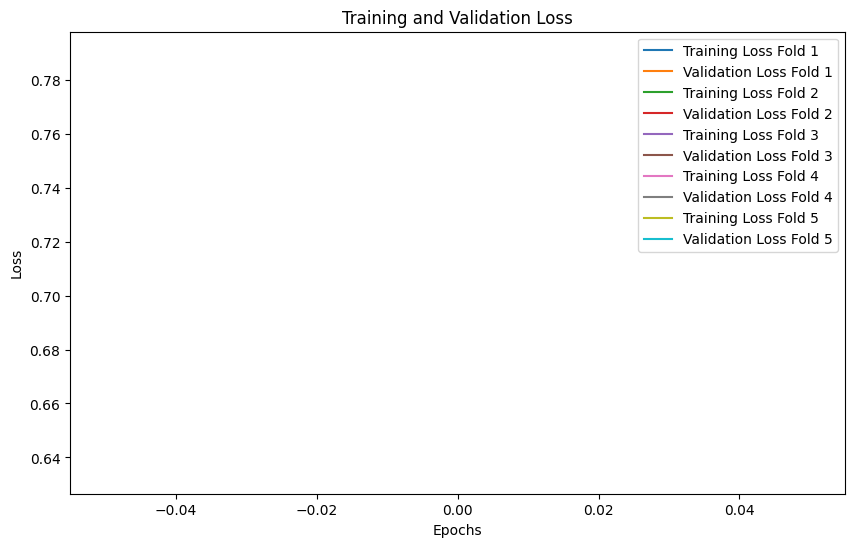

Evaluating model 0...
Prefix length: 1
Preparing data...
29/29 [==============================] - 2s 18ms/step
Prefix length: 2
Preparing data...
29/29 [==============================] - 1s 21ms/step
Prefix length: 3
Preparing data...
28/28 [==============================] - 1s 20ms/step
Prefix length: 4
Preparing data...
12/12 [==============================] - 0s 18ms/step
Prefix length: 5
Preparing data...
5/5 [==============================] - 0s 18ms/step
Prefix length: 6
Preparing data...
2/2 [==============================] - 0s 10ms/step
Prefix length: 7
Preparing data...
1/1 [==============================] - 0s 80ms/step
Prefix length: 8
Preparing data...
1/1 [==============================] - 0s 134ms/step
Prefix length: 9
Preparing data...
1/1 [==============================] - 0s 154ms/step
Prefix length: 10
Preparing data...
1/1 [==============================] - 0s 126ms/step
Prefix length: 11
Preparing data...
1/1 [==============================] - 0s 113ms/step
Prefix 

In [4]:
# args_helpdesk = {
#         "dataset_name": "helpdesk",
#         "filepath": "helpdesk.csv",
#         "columns": ["Case ID", "Activity", "Complete Timestamp"],
#         "additional_columns": {},
#         "datetime_format": "%Y-%m-%d %H:%M:%S.%f",
#         "model_learning_rate": 0.001,
#         "model_epochs": 3,
#         "model_num_layers": 1,
#         "target_columns": {"Complete Timestamp": Target.NEXT_FEATURE},
#         "input_columns": ["Activity"],
#         "temporal_features": {Temporal_Feature.DAY_OF_WEEK: False, Temporal_Feature.HOUR_OF_DAY: False},
#         "model_architecture": Model_Architecture.COMMON_POSEMBS_TRANSF
#         }

args_helpdesk = {
        "dataset_name": "helpdesk",
        "filepath": "helpdesk.csv",
        "columns": ["Case ID", "Activity", "Complete Timestamp"],
        "additional_columns": {Feature_Type.CATEGORICAL: ["Resource"]},
        "datetime_format": "%Y-%m-%d %H:%M:%S.%f",
        "model_epochs": 1,
        "model_num_layers": 1,
        "target_columns": {"Activity": Target.NEXT_FEATURE},
        "input_columns": ["Activity", "Resource", "Complete Timestamp"],
        "temporal_features": {Temporal_Feature.DAY_OF_WEEK: False, Temporal_Feature.HOUR_OF_DAY: False},
        "model_architecture": Model_Architecture.COMMON_POSEMBS_TRANSF,
        "sorting": False,
        "cross_val": True
        }

# args_helpdesk = {
#         "dataset_name": "helpdesk",
#         "filepath": "helpdesk.csv",
#         "columns": ["Case ID", "Activity", "Complete Timestamp"],
#         "additional_columns": {Feature_Type.CATEGORICAL: ["Resource"]},
#         "datetime_format": "%Y-%m-%d %H:%M:%S.%f",
#         "model_learning_rate": 0.001,
#         "model_epochs": 1,
#         "model_num_layers": 1,
#         "target_columns": {"Activity": Target.NEXT_FEATURE},
#         "input_columns": ["Activity", "Resource", "Complete Timestamp"],
#         "temporal_features": {Temporal_Feature.DAY_OF_WEEK: True, Temporal_Feature.HOUR_OF_DAY: True}
#         }

args_sepsis = {
        "dataset_name": "sepsis",
        "filepath": "sepsis.xes",
        "columns": ["case:concept:name", "concept:name", "time:timestamp"],
        "additional_columns": {Feature_Type.CATEGORICAL: ["org:group"]},
        "datetime_format": "%Y-%m-%d %H:%M:%S%z",
        "model_learning_rate": 0.001,
        "model_epochs": 1,
        "model_num_layers": 10,
        "target_columns": {"concept:name": Target.NEXT_FEATURE},
        "input_columns": ["concept:name", "org:group"],
        "temporal_features": {Temporal_Feature.DAY_OF_WEEK: True, Temporal_Feature.HOUR_OF_DAY: True}
        }

args_bpi_2012 = {
        "dataset_name": "bpi_2012",
        "filepath": "BPI_Challenge_2012.xes",
        "columns": ["case:concept:name", "concept:name", "time:timestamp"],
        "additional_columns": {Feature_Type.CATEGORICAL: ["org:resource"]},
        "datetime_format": None,
        "model_learning_rate": 0.001,
        "model_epochs": 10,
        "model_num_layers": 1,
        "target_columns": {"concept:name": Target.NEXT_FEATURE},
        "input_columns": ["concept:name", "org:resource"]
        }

args_bpi_2013 = {
        "dataset_name": "bpi_2013",
        "filepath": "BPI_Challenge_2013_incidents.xes",
        "columns": ["case:concept:name", "concept:name", "time:timestamp"],
        "additional_columns": {Feature_Type.CATEGORICAL: ["org:resource"]},
        "datetime_format": "%Y-%m-%d %H:%M:%S%z",
        "model_learning_rate": 0.001,
        "model_epochs": 2,
        "model_num_layers": 1,
        "target_columns": {"concept:name": Target.NEXT_FEATURE},
        "input_columns": ["concept:name", "org:resource"]
        }

args_bpi_2015_1 = {
        "dataset_name": "bpi_2015_1",
        "filepath": "BPIC15_1.xes",
        "columns": ["case:concept:name", "concept:name", "time:timestamp"],
        "additional_columns": {Feature_Type.CATEGORICAL: ["org:resource"]},
        "datetime_format": "%Y-%m-%d %H:%M:%S%z",
        "model_learning_rate": 0.001,
        "model_epochs": 2,
        "model_num_layers": 1,
        "target_columns": {"concept_name": Target.NEXT_FEATURE},
        "input_columns": ["concept_name", "org_resource"]
        }


run(args_helpdesk)
# preprocess(args_helpdesk)

In [5]:
# # change settings and run again

# args_bpi_2012["additional_columns"] = {}
# args_bpi_2012["input_columns"] = ["concept:name"]
# run(args_bpi_2012)

In [6]:
# run(additional_columns={Feature_Type.CATEGORICAL: ["Resource"]}, input_columns=["Activity", "Resource"], target_columns=["Activity"])

In [7]:
# run(additional_columns={Feature_Type.CATEGORICAL: ["Resource"]}, input_columns=["Activity", "Resource"], target_columns=["Activity", "Resource"])